Deep Sets
===============================================================

We will start by looking at Deep Sets networks using PyTorch. The architecture is based on the following paper: [DeepSets](https://papers.nips.cc/paper/2017/file/f22e4747da1aa27e363d86d40ff442fe-Paper.pdf)

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm
import numpy as np

In [ ]:
# For Colab

!pip install wget
import wget

!pip install -U PyYAML
!pip install uproot
!pip install awkward

In [2]:
import yaml

# WGET for colab
url = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/definitions_lorentz.yml"
definitionsFile = wget.download(url)

# with open('definitions_lorentz.yml') as file: #If you pulled locally
with open(definitionsFile) as file:  # for colab
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)

features = definitions["features"]
spectators = definitions["spectators"]
labels = definitions["labels"]

nfeatures = definitions["nfeatures"]
nspectators = definitions["nspectators"]
nlabels = definitions["nlabels"]
ntracks = definitions["ntracks"]

## Dataset loader
Here we have to define the dataset loader. 



In [3]:
# If in colab
urlDSD = "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/DeepSetsDataset.py"
DSD = wget.download(urlDSD)
urlUtils = (
    "https://raw.githubusercontent.com/jmduarte/iaifi-summer-school/main/book/utils.py"
)
utils = wget.download(urlUtils)

from DeepSetsDataset import DeepSetsDataset

# For colab
import os.path

if not os.path.exists("ntuple_merged_90.root"):
    urlFILE = "http://opendata.cern.ch/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_90.root"
    dataFILE = wget.download(urlFILE)
train_files = ["ntuple_merged_90.root"]

##Locally with XRootD
# train_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_11.root']
# test_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_1.root']

train_generator = DeepSetsDataset(
    features,
    labels,
    spectators,
    start_event=0,
    stop_event=10000,
    npad=ntracks,
    file_names=train_files,
)
train_generator.process()

test_generator = DeepSetsDataset(
    features,
    labels,
    spectators,
    start_event=10001,
    stop_event=14001,
    npad=ntracks,
    file_names=train_files,
)
test_generator.process()

  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/drankin/Documents/iaifi-summer-school/book/DeepSetsDataset.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/torch/csrc/utils/tensor_new.cpp:210.)
  x = torch.tensor([feature_array[feat][i].to_numpy() for feat in self.features], dtype=torch.float)


  0%|          | 0/4000 [00:00<?, ?it/s]

## Deep Sets Network

Deep Sets models are designed to be explicitly permutation invariant. At their core they are composed of two networks, $\phi$ and $\rho$, such that the total network $f$ is given by

$
\begin{align}
    f &= \rho\left(\Sigma_{\mathbf{x}_i\in\mathcal{X}}\phi(\mathbf{x}_i)\right)
  \label{eq:deepsets-functions}
\end{align}
$

where $\mathbf{x}_i$ are the features for the i-th element in the input sequence $\mathcal{X}$.

We will define a DeepSets model that will take as input up to 60 of the tracks (with 48 features) with zero-padding.

In [4]:
# For Colab again
!pip install torch_scatter

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import (
    Sequential as Seq,
    Linear as Lin,
    ReLU,
    BatchNorm1d,
    AvgPool1d,
    Sigmoid,
    Conv1d,
)
from torch_scatter import scatter_mean

# ntracks = 60
inputs = 6
hidden1 = 64
hidden2 = 32
hidden3 = 16
classify1 = 50
outputs = 2


class DeepSets(torch.nn.Module):
    def __init__(self):
        super(DeepSets, self).__init__()
        self.phi = Seq(
            Conv1d(inputs, hidden1, 1),
            BatchNorm1d(hidden1),
            ReLU(),
            Conv1d(hidden1, hidden2, 1),
            BatchNorm1d(hidden2),
            ReLU(),
            Conv1d(hidden2, hidden3, 1),
            BatchNorm1d(hidden3),
            ReLU(),
        )
        self.rho = Seq(
            Lin(hidden3, classify1),
            BatchNorm1d(classify1),
            ReLU(),
            Lin(classify1, outputs),
            Sigmoid(),
        )

    def forward(self, x):
        out = self.phi(x)
        out = scatter_mean(out, torch.LongTensor(np.zeros(ntracks)), dim=-1)
        return self.rho(torch.squeeze(out))


model = DeepSets()
print(model)
print("----------")
print({l: model.state_dict()[l].shape for l in model.state_dict()})

model = DeepSets().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

DeepSets(
  (phi): Sequential(
    (0): Conv1d(6, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (rho): Sequential(
    (0): Linear(in_features=16, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=2, bias=True)
    (4): Sigmoid()
  )
)
----------
{'phi.0.weight': torch.Size([64, 6, 1]), 'phi.0.bias': torch.Size([64]), 'phi.1.weight': torch.Size([64]), 'phi.1.bias': torch.Size([64]), 'phi.1.running_mean': torch.Size([64]), 'phi.1.running_var': torch

## Define training loop

In [5]:
@torch.no_grad()
def test(model, loader, total, batch_size, leave=False):
    model.eval()

    xentropy = nn.CrossEntropyLoss(reduction="mean")

    sum_loss = 0.0
    t = tqdm(enumerate(loader), total=total / batch_size, leave=leave)
    for i, data in t:
        x = data[0].to(device)
        y = data[1].to(device)
        y = torch.argmax(y, dim=1)
        batch_output = model(x)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh()  # to show immediately the update

    return sum_loss / (i + 1)


def train(model, optimizer, loader, total, batch_size, leave=False):
    model.train()

    xentropy = nn.CrossEntropyLoss(reduction="mean")

    sum_loss = 0.0
    t = tqdm(enumerate(loader), total=total / batch_size, leave=leave)
    for i, data in t:
        x = data[0].to(device)
        y = data[1].to(device)
        y = torch.argmax(y, dim=1)
        optimizer.zero_grad()
        batch_output = model(x)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh()  # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()

    return sum_loss / (i + 1)

## Define training, validation, testing data generators

In [6]:
from torch.utils.data import ConcatDataset

train_generator_data = ConcatDataset(train_generator.datas)
test_generator_data = ConcatDataset(test_generator.datas)

In [7]:
from torch.utils.data import random_split, DataLoader

torch.manual_seed(0)
valid_frac = 0.20
train_length = len(train_generator_data)
valid_num = int(valid_frac * train_length)
batch_size = 32

train_dataset, valid_dataset = random_split(
    train_generator_data, [train_length - valid_num, valid_num]
)


def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# train_loader.collate_fn = collate
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
# valid_loader.collate_fn = collate
test_loader = DataLoader(test_generator_data, batch_size=batch_size, shuffle=False)
# test_loader.collate_fn = collate

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_generator_data)
print(train_length)
print(train_samples)
print(valid_samples)
print(test_samples)

9365
7492
1873
3739


## Train

In [8]:
import os.path as osp

n_epochs = 30
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(
        model,
        optimizer,
        train_loader,
        train_samples,
        batch_size,
        leave=bool(epoch == n_epochs - 1),
    )
    valid_loss = test(
        model,
        valid_loader,
        valid_samples,
        batch_size,
        leave=bool(epoch == n_epochs - 1),
    )
    print("Epoch: {:02d}, Training Loss:   {:.4f}".format(epoch, loss))
    print("           Validation Loss: {:.4f}".format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join("deepsets_best.pth")
        print("New best model saved to:", modpath)
        torch.save(model.state_dict(), modpath)
        stale_epochs = 0
    else:
        print("Stale epoch")
        stale_epochs += 1
    if stale_epochs >= patience:
        print("Early stopping after %i stale epochs" % patience)
        break

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/234.125 [00:00<?, ?it/s]

  0%|          | 0/58.53125 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   0.4550
           Validation Loss: 0.4328
New best model saved to: deepsets_best.pth


  0%|          | 0/234.125 [00:00<?, ?it/s]

  0%|          | 0/58.53125 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   0.4439
           Validation Loss: 0.4307
New best model saved to: deepsets_best.pth


  0%|          | 0/234.125 [00:00<?, ?it/s]

  0%|          | 0/58.53125 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   0.4438
           Validation Loss: 0.4328
Stale epoch


  0%|          | 0/234.125 [00:00<?, ?it/s]

  0%|          | 0/58.53125 [00:00<?, ?it/s]

Epoch: 03, Training Loss:   0.4415
           Validation Loss: 0.4328
Stale epoch


  0%|          | 0/234.125 [00:00<?, ?it/s]

  0%|          | 0/58.53125 [00:00<?, ?it/s]

Epoch: 04, Training Loss:   0.4424
           Validation Loss: 0.4328
Stale epoch


  0%|          | 0/234.125 [00:00<?, ?it/s]

  0%|          | 0/58.53125 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   0.4411
           Validation Loss: 0.4328
Stale epoch


  0%|          | 0/234.125 [00:00<?, ?it/s]

  0%|          | 0/58.53125 [00:00<?, ?it/s]

Epoch: 06, Training Loss:   0.4422
           Validation Loss: 0.4316
Stale epoch
Early stopping after 5 stale epochs


## Evaluate on testing data

In [14]:
model.eval()
t = tqdm(enumerate(test_loader), total=test_samples / batch_size)
y_test = []
y_predict = []
track_pt = []
for i, data in t:
    x = data[0].to(device)
    y = data[1].to(device)
    track_pt.append(x[:, 0, 0].numpy())
    batch_output = model(x)
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(y.cpu().numpy())
track_pt = np.concatenate(track_pt)
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

  0%|          | 0/116.84375 [00:00<?, ?it/s]

[]

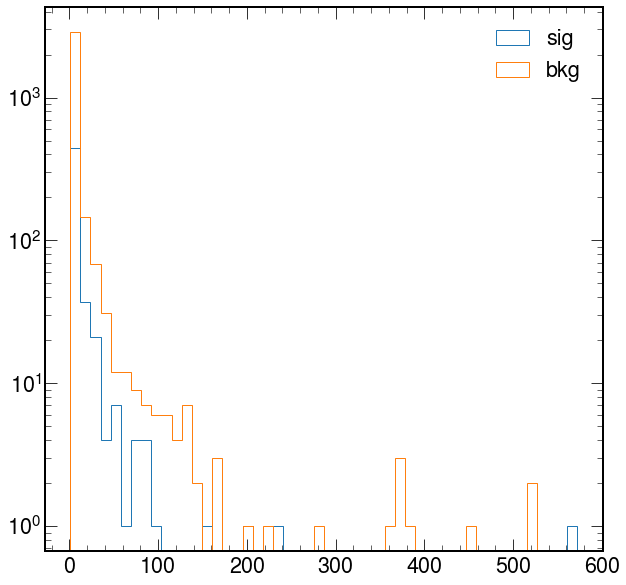

In [20]:
# For Colab
from matplotlib import pyplot as plt

_, bins, _ = plt.hist(
    track_pt[y_test[:, 1] == 1], bins=50, label="sig", histtype="step"
)
_, bins, _ = plt.hist(
    track_pt[y_test[:, 1] == 0], bins=bins, label="bkg", histtype="step"
)
plt.legend()
plt.semilogy()

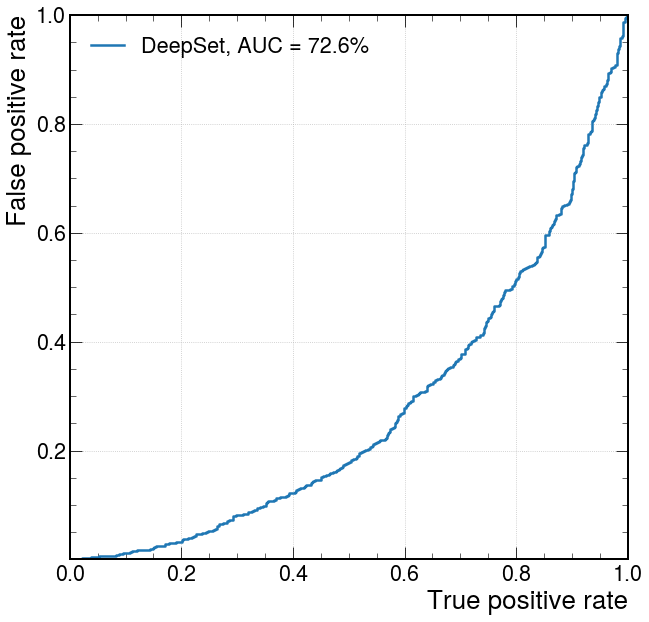

In [21]:
!pip install mplhep

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_deepset, tpr_deepset, threshold_deepset = roc_curve(y_test[:, 1], y_predict[:, 1])
with open("deepset_roc.npy", "wb") as f:
    np.save(f, fpr_deepset)
    np.save(f, tpr_deepset)
    np.save(f, threshold_deepset)

# plot ROC curves
plt.figure()
plt.plot(
    tpr_deepset,
    fpr_deepset,
    lw=2.5,
    label="DeepSet, AUC = {:.1f}%".format(auc(fpr_deepset, tpr_deepset) * 100),
)
plt.xlabel(r"True positive rate")
plt.ylabel(r"False positive rate")
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [11]:
model.eval()
t = tqdm(enumerate(test_loader), total=test_samples / batch_size)
y_test = []
y_predict = []
track_pt = []
for i, data in t:
    x = data[0].to(device)
    y = data[1].to(device)
    idx = torch.randperm(x.size(2))
    x = x[:, :, idx]
    track_pt.append(x[:, 0, 0].numpy())
    batch_output = model(x)
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(y.cpu().numpy())
track_pt = np.concatenate(track_pt)
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

  0%|          | 0/116.84375 [00:00<?, ?it/s]

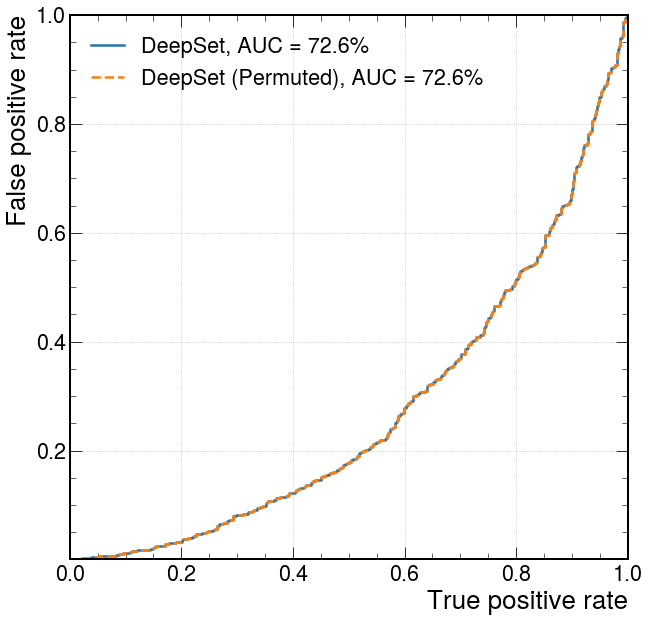

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_deepset_perm, tpr_deepset_perm, threshold_deepset_perm = roc_curve(
    y_test[:, 1], y_predict[:, 1]
)
with open("deepset_perm_roc.npy", "wb") as f:
    np.save(f, fpr_deepset)
    np.save(f, tpr_deepset)
    np.save(f, threshold_deepset)

with open("deepset_roc.npy", "rb") as f:
    fpr_deepset = np.load(f)
    tpr_deepset = np.load(f)
    threshold_deepset = np.load(f)

# plot ROC curves
plt.figure()
plt.plot(
    tpr_deepset,
    fpr_deepset,
    lw=2.5,
    label="DeepSet, AUC = {:.1f}%".format(auc(fpr_deepset, tpr_deepset) * 100),
)
plt.plot(
    tpr_deepset_perm,
    fpr_deepset_perm,
    lw=2.5,
    label="DeepSet (Permuted), AUC = {:.1f}%".format(
        auc(fpr_deepset_perm, tpr_deepset_perm) * 100
    ),
    linestyle="dashed",
)
plt.xlabel(r"True positive rate")
plt.ylabel(r"False positive rate")
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

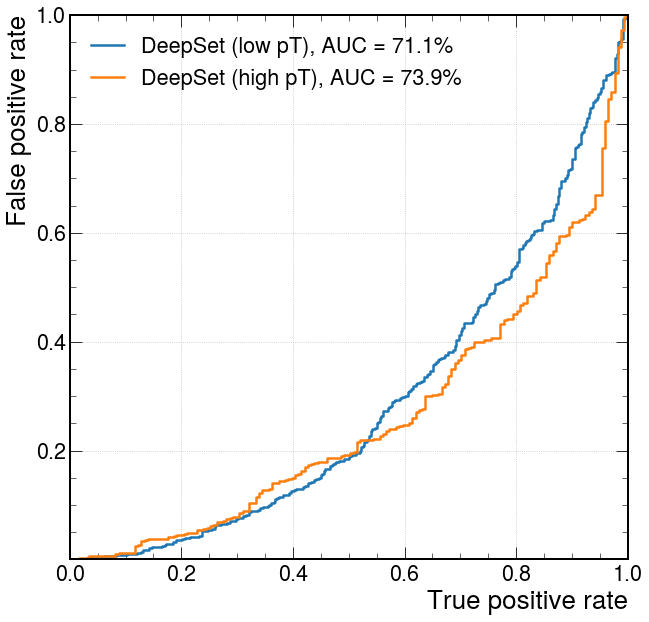

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.ROOT)
# create ROC curves
pt_split = 5.0
fpr_deepset_lowb, tpr_deepset_lowb, threshold_deepset_lowb = roc_curve(
    y_test[track_pt <= pt_split, 1], y_predict[track_pt <= pt_split, 1]
)
fpr_deepset_highb, tpr_deepset_highb, threshold_deepset_highb = roc_curve(
    y_test[track_pt > pt_split, 1], y_predict[track_pt > pt_split, 1]
)

# plot ROC curves
plt.figure()
plt.plot(
    tpr_deepset_lowb,
    fpr_deepset_lowb,
    lw=2.5,
    label="DeepSet (low pT), AUC = {:.1f}%".format(
        auc(fpr_deepset_lowb, tpr_deepset_lowb) * 100
    ),
)
plt.plot(
    tpr_deepset_highb,
    fpr_deepset_highb,
    lw=2.5,
    label="DeepSet (high pT), AUC = {:.1f}%".format(
        auc(fpr_deepset_highb, tpr_deepset_highb) * 100
    ),
)
plt.xlabel(r"True positive rate")
plt.ylabel(r"False positive rate")
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc="upper left")
plt.show()